<a href="https://colab.research.google.com/github/deveenas/mlproject/blob/main/FinalProject_ML_gr_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To estimate the Bicycle parking volume in Toronto

Import the required packages and load the dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from joblib import Memory
import os
import tempfile

print("Current working directory:", os.getcwd())
# Load the dataset
#file_path = os.path.join(os.getcwd(), 'data/raw/volumes_atr_cyclists_shortterm.csv')
file_path = os.path.join(os.getcwd(), 'volumes_atr_cyclists_shortterm.csv')
df = pd.read_csv(file_path)



Current working directory: /content


In [ ]:
# Convert datetime strings to datetime objects
df['datetime_bin_start'] = pd.to_datetime(df['datetime_bin_start'])
df.describe()

,centreline_id,daily_temperature,daily_precipitation,datetime_bin_start,volume
count,2.804600e+04,27064.000000,27064.000000,28046,28046.000000
mean,1.461725e+07,22.106710,2.912208,2015-03-06 17:51:49.020894208,37.214006
min,1.123740e+05,5.000000,0.000000,2010-03-17 00:00:00,0.000000
25%,7.929510e+06,18.000000,0.000000,2013-06-02 12:15:00,3.000000
50%,1.401616e+07,23.000000,0.000000,2015-05-22 19:00:00,15.000000
75%,3.000543e+07,27.000000,1.000000,2017-05-08 21:45:00,46.000000
max,3.009906e+07,38.000000,70.000000,2018-10-10 23:00:00,712.000000
std,1.032856e+07,6.272306,7.524519,NaN,59.161384


Time Series Plot of Cyclist Volume

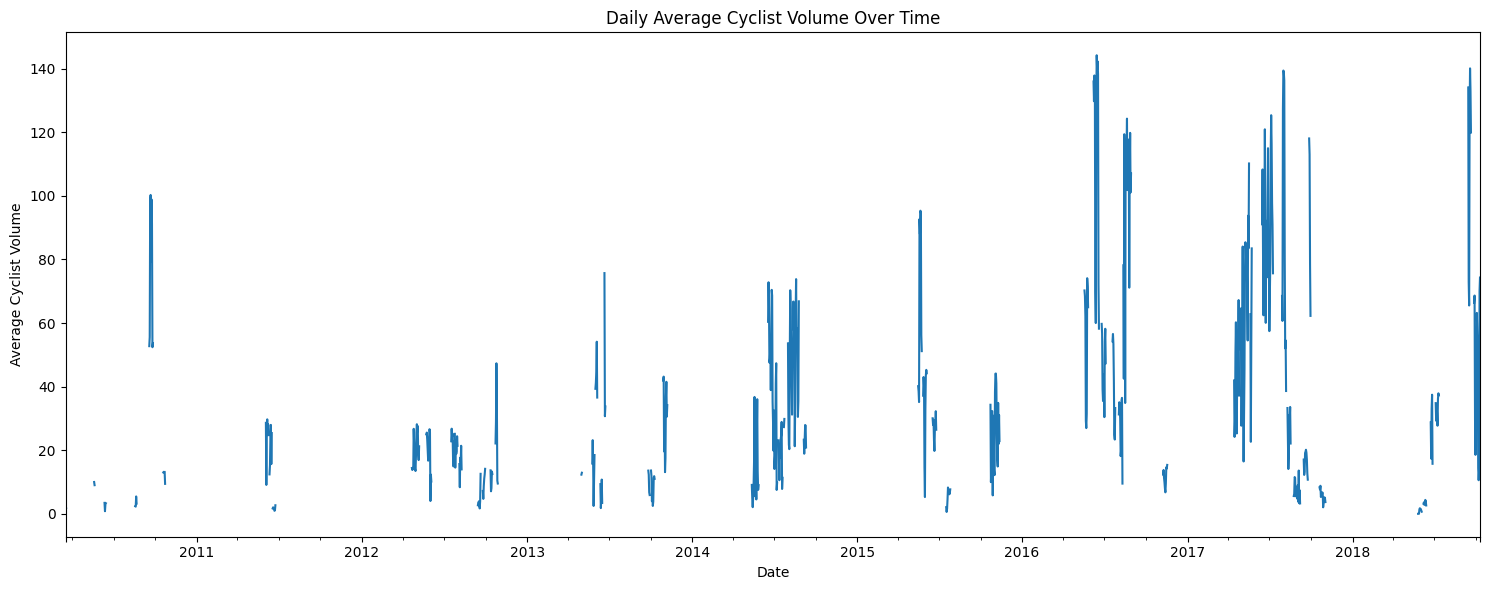

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
df.set_index('datetime_bin_start')['volume'].resample('D').mean().plot()
plt.title('Daily Average Cyclist Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Average Cyclist Volume')
plt.tight_layout()
plt.show()

Heatmap of Cyclist Volume by Hour and Day of Week

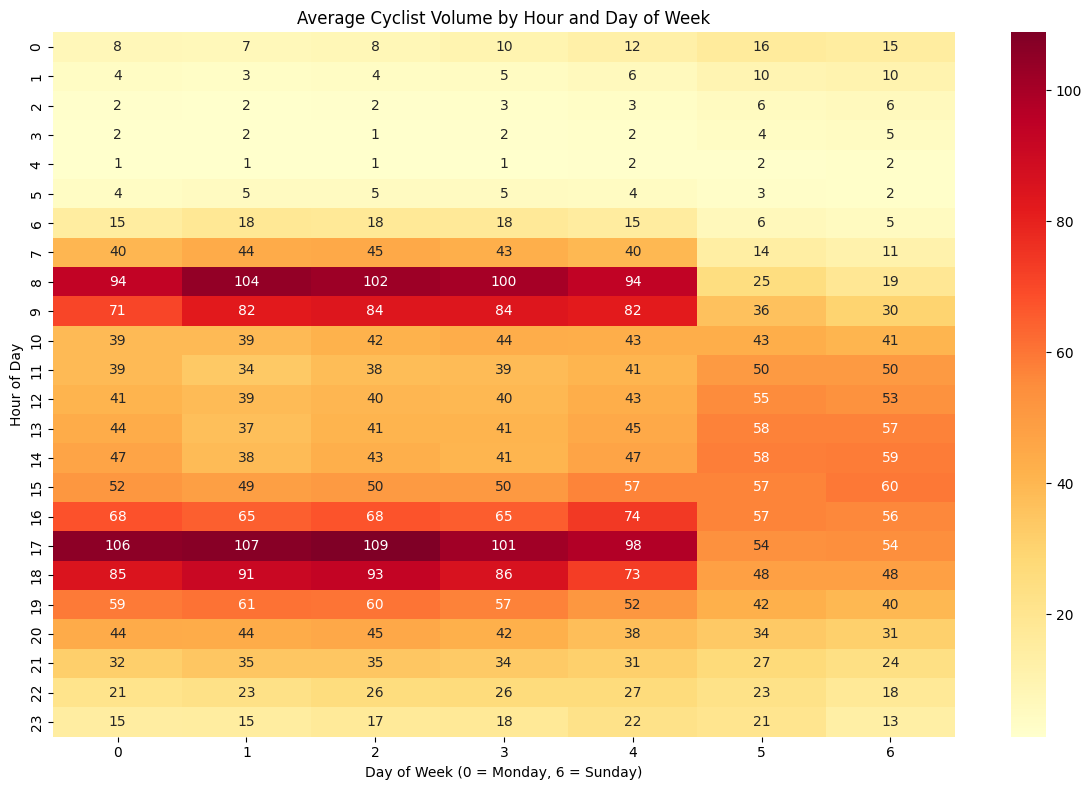

In [ ]:
df['day_of_week'] = df['datetime_bin_start'].dt.dayofweek
df['hour'] = df['datetime_bin_start'].dt.hour

pivot = df.pivot_table(values='volume', index='hour', columns='day_of_week', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Average Cyclist Volume by Hour and Day of Week')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()

Scatter Plot of Temperature vs Cyclist Volume

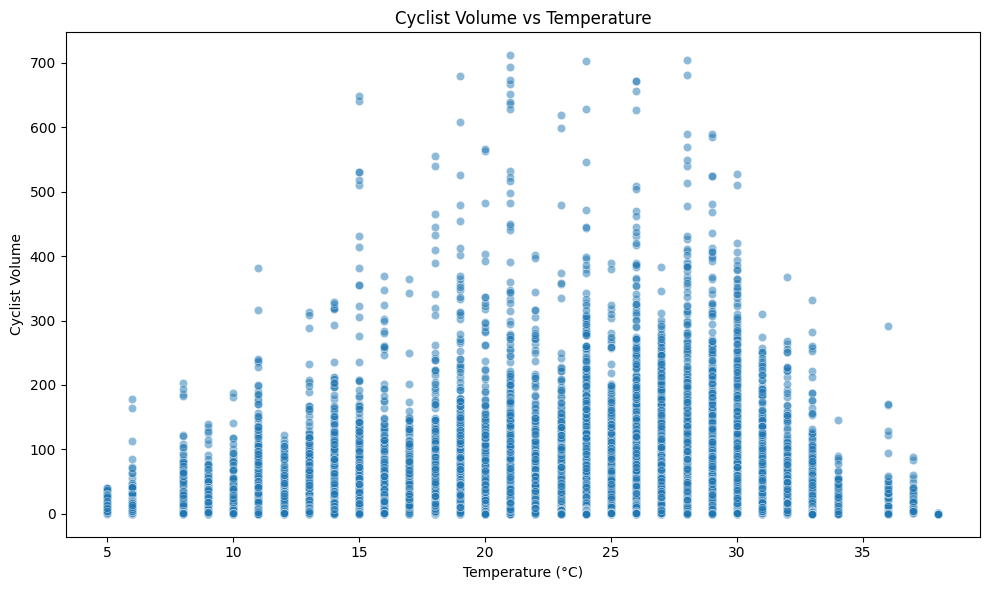

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='daily_temperature', y='volume', data=df, alpha=0.5)
plt.title('Cyclist Volume vs Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Cyclist Volume')
plt.tight_layout()
plt.show()

Bar Plot of Average Cyclist Volume by Direction

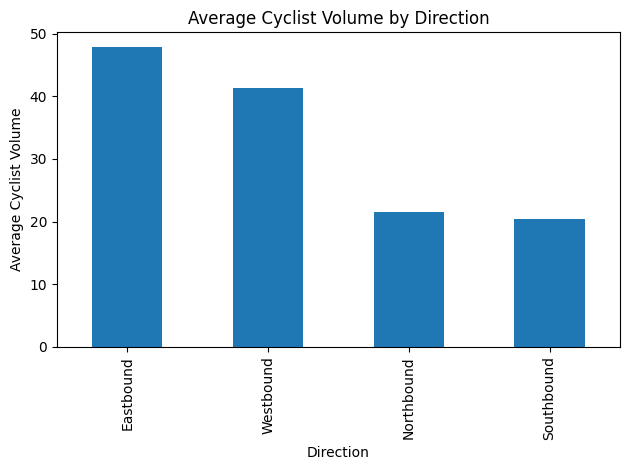

In [ ]:
df.groupby('direction')['volume'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Average Cyclist Volume by Direction')
plt.xlabel('Direction')
plt.ylabel('Average Cyclist Volume')
plt.tight_layout()
plt.show()

Extract additional time-based features

In [ ]:
df['hour'] = df['datetime_bin_start'].dt.hour
df['day_of_week'] = df['datetime_bin_start'].dt.dayofweek
df['month'] = df['datetime_bin_start'].dt.month

In [ ]:
# Define features
numeric_features = ['hour', 'day_of_week', 'month', 'daily_temperature', 'daily_precipitation']
categorical_features = [ 'direction','location','class_type']

# Combine all features
features = numeric_features + categorical_features
X = df[features]
y = df['volume']

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create a temporary directory for caching
cachedir = tempfile.mkdtemp()

# Initialize memory for caching
memory = Memory(location=cachedir, verbose=0)

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Support Vector Regression (SVR) model

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

svr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', SVR())])

svr_pipeline.fit(X_train, y_train)
svr_predictions = svr_pipeline.predict(X_test)

svr_mse = mean_squared_error(y_test, svr_predictions)
svr_r2 = r2_score(y_test, svr_predictions)

print("\nSupport Vector Regression Results:")
print(f"Mean Squared Error: {svr_mse}")
print(f"R2 Score: {svr_r2}")


Support Vector Regression Results:
Mean Squared Error: 2604.806651510767
R2 Score: 0.24585456994800547


Gradient Boosting Regression model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', GradientBoostingRegressor(random_state=42))
                               ], memory=memory)

gbr_pipeline.fit(X_train, y_train)
gbr_predictions = gbr_pipeline.predict(X_test)

gbr_mse = mean_squared_error(y_test, gbr_predictions)
gbr_r2 = r2_score(y_test, gbr_predictions)

print("\nGradient Boosting Regression Results:")
print(f"Mean Squared Error: {gbr_mse}")
print(f"R2 Score: {gbr_r2}")


Gradient Boosting Regression Results:
Mean Squared Error: 1686.6199945687417
R2 Score: 0.5116886082885992


K-Nearest Neighbors Regression model

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', KNeighborsRegressor())])

knn_pipeline.fit(X_train, y_train)
knn_predictions = knn_pipeline.predict(X_test)

knn_mse = mean_squared_error(y_test, knn_predictions)
knn_r2 = r2_score(y_test, knn_predictions)

print("\nK-Nearest Neighbors Regression Results:")
print(f"Mean Squared Error: {knn_mse}")
print(f"R2 Score: {knn_r2}")


K-Nearest Neighbors Regression Results:
Mean Squared Error: 1223.995393939394
R2 Score: 0.6456280038256539


Random Forest Regression Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(random_state=42))])

# Define the parameter grid
param_grid = {
    'regressor__n_estimators': [80,100],
    'regressor__max_depth': [30,40],
    'regressor__min_samples_split': [2,4],
    'regressor__min_samples_leaf': [3,5]
}

# Create the grid search object
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best negative MSE:", grid_search.best_score_)

# Use the best model for predictions
best_rf_model = grid_search.best_estimator_
rf_predictions = best_rf_model.predict(X_test)

# Evaluate the model
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("\nRandom Forest Regression Results:")
print(f"Mean Squared Error: {rf_mse}")
print(f"R2 Score: {rf_r2}")

Best parameters: {'regressor__max_depth': 40, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 80}
Best negative MSE: -669.9702088105089

Random Forest Regression Results:
Mean Squared Error: 583.97912854029
R2 Score: 0.830925957295535


Scatter plot of Actual and Predicted Values

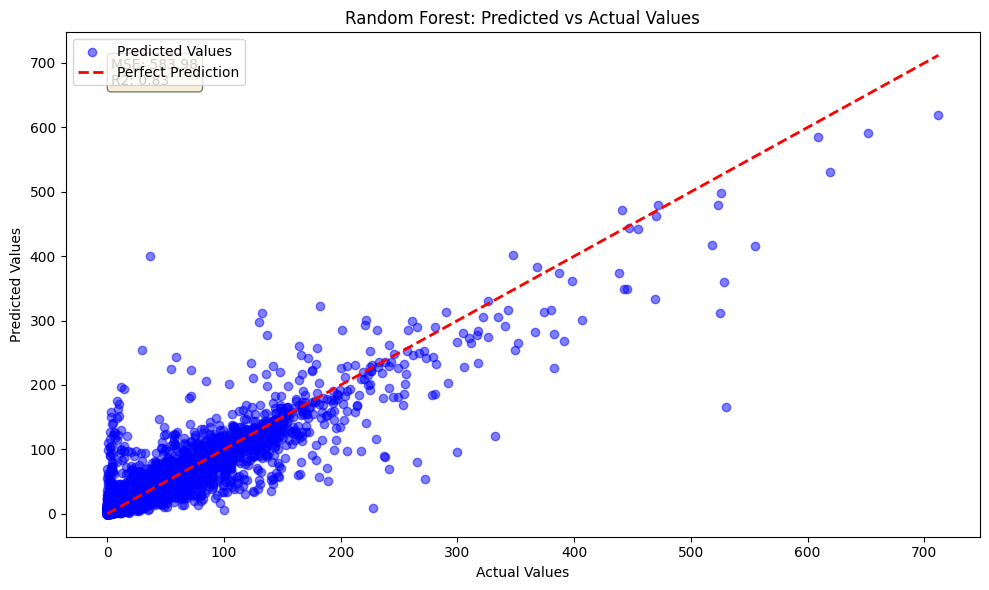

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_predictions, alpha=0.5, c='blue', label='Predicted Values')

# Add a diagonal line representing perfect predictions
min_val = min(y_test.min(), rf_predictions.min())
max_val = max(y_test.max(), rf_predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

# Customize the plot
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Predicted vs Actual Values')

# Add text box with performance metrics
textstr = f'MSE: {rf_mse:.2f}\nR2: {rf_r2:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

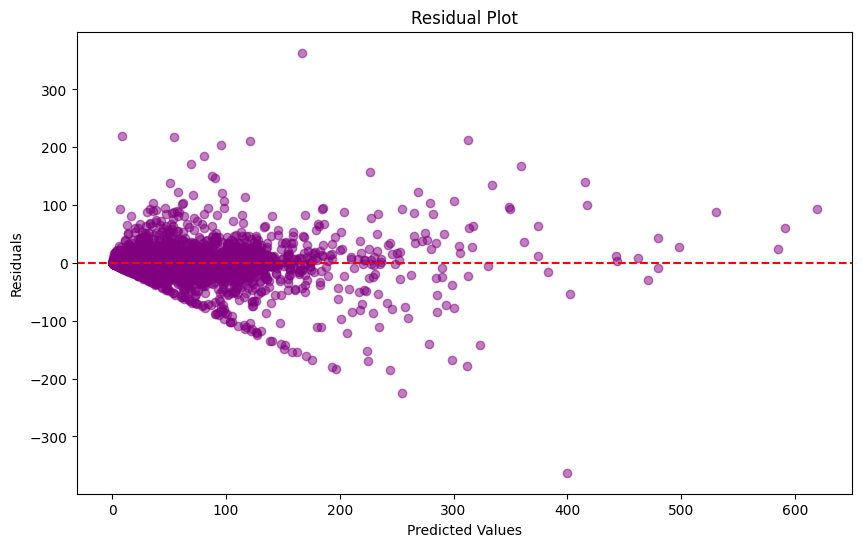

In [ ]:
import matplotlib.pyplot as plt

residuals = y_test - rf_predictions

plt.figure(figsize=(10, 6))
plt.scatter(rf_predictions, residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()